In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats

%matplotlib inline
from matplotlib import font_manager, rc

font_location = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False


# 혈당 데이터 유의성 찾기

In [4]:

df = pd.read_csv("국민건강보험공단_건강검진정보_2024.CSV", encoding="cp949")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 33 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   기준년도           1000000 non-null  int64  
 1   가입자일련번호        1000000 non-null  int64  
 2   시도코드           1000000 non-null  int64  
 3   성별코드           1000000 non-null  int64  
 4   연령대코드(5세단위)    1000000 non-null  int64  
 5   신장(5cm단위)      1000000 non-null  int64  
 6   체중(5kg단위)      1000000 non-null  int64  
 7   허리둘레           999505 non-null   float64
 8   시력(좌)          999807 non-null   float64
 9   시력(우)          999808 non-null   float64
 10  청력(좌)          999852 non-null   float64
 11  청력(우)          999852 non-null   float64
 12  수축기혈압          994210 non-null   float64
 13  이완기혈압          994211 non-null   float64
 14  식전혈당(공복혈당)     994153 non-null   float64
 15  총콜레스테롤         342400 non-null   float64
 16  트리글리세라이드       342395 non-null   float64
 17  HDL콜레스테롤 

In [6]:
df = pd.read_csv("국민건강보험공단_건강검진정보_2024.CSV", encoding="cp949")
df['고혈당_분석용'] = (df['식전혈당(공복혈당)'] >= 126).astype(int)  
df['고혈당_서비스용'] = (df['식전혈당(공복혈당)'] >= 100).astype(int)   

In [7]:
df

,기준년도,가입자일련번호,시도코드,성별코드,연령대코드(5세단위),신장(5cm단위),체중(5kg단위),허리둘레,시력(좌),시력(우),...,흡연상태,음주여부,구강검진수검여부,치아우식증유무,결손치 유무,치아마모증유무,제3대구치(사랑니) 이상,치석,고혈당_분석용,고혈당_서비스용
0,2024,4831755,41,2,13,160,50,70.0,1.0,1.0,...,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN,0,0
1,2024,1154608,41,2,11,155,60,74.9,1.0,1.0,...,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN,0,0
2,2024,3318236,41,2,13,150,55,74.0,1.0,1.0,...,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN,0,1
3,2024,3770599,41,1,16,160,70,89.0,1.0,1.0,...,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN,0,0
4,2024,2634185,41,1,11,175,65,76.0,1.0,1.0,...,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2024,1945007,27,2,17,150,45,76.2,0.4,0.3,...,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,1,1
999996,2024,2558884,28,1,12,160,70,86.1,0.7,0.7,...,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,0,0
999997,2024,4441437,41,1,12,160,65,78.5,0.9,0.9,...,3.0,0.0,0,NaN,NaN,NaN,NaN,NaN,0,0
999998,2024,4313591,30,1,8,175,95,105.0,1.5,1.5,...,1.0,0.0,1,0.0,NaN,NaN,NaN,0.0,0,1


In [ ]:
num_cols = [
    '신장(5cm단위)', '체중(5kg단위)', '허리둘레', '수축기혈압', '이완기혈압',
    '총콜레스테롤','트리글리세라이드','HDL콜레스테롤','LDL콜레스테롤',
    '혈색소','혈청크레아티닌','혈청지오티(AST)','혈청지피티(ALT)','감마지티피'
]

cat_cols = ['성별코드','흡연상태','음주여부'] 

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

def run_tests(target_col):
    results = []
    for col in num_cols + cat_cols:
        if col in cat_cols:
            contingency = pd.crosstab(df[col], df[target_col])
            chi2, p, _, _ = stats.chi2_contingency(contingency)
            method = "카이제곱검정"
        else:
            group0 = df[df[target_col]==0][col]
            group1 = df[df[target_col]==1][col]
            t, p = stats.ttest_ind(group0, group1, equal_var=False)
            method = "t-검정"
        results.append([col, method, p])
    return pd.DataFrame(results, columns=['변수','검정방법','p-value']).sort_values("p-value")

print("📊 126 기준 (분석용)")
results_analysis = run_tests('고혈당_분석용')
print(results_analysis[results_analysis['p-value'] < 0.05])

print("\n📊 100 기준 (서비스용)")
results_service = run_tests('고혈당_서비스용')
print(results_service[results_service['p-value'] < 0.05])

📊 126 기준 (분석용)
            변수    검정방법        p-value
8     LDL콜레스테롤    t-검정   0.000000e+00
1    체중(5kg단위)    t-검정   0.000000e+00
2         허리둘레    t-검정   0.000000e+00
3        수축기혈압    t-검정   0.000000e+00
4        이완기혈압    t-검정   0.000000e+00
5       총콜레스테롤    t-검정   0.000000e+00
6     트리글리세라이드    t-검정   0.000000e+00
7     HDL콜레스테롤    t-검정   0.000000e+00
15        흡연상태  카이제곱검정   0.000000e+00
9          혈색소    t-검정   0.000000e+00
11  혈청지오티(AST)    t-검정   0.000000e+00
12  혈청지피티(ALT)    t-검정   0.000000e+00
13       감마지티피    t-검정   0.000000e+00
14        성별코드  카이제곱검정   0.000000e+00
10     혈청크레아티닌    t-검정  2.122501e-279
16        음주여부  카이제곱검정  1.302313e-218

📊 100 기준 (서비스용)
            변수    검정방법        p-value
8     LDL콜레스테롤    t-검정   0.000000e+00
1    체중(5kg단위)    t-검정   0.000000e+00
2         허리둘레    t-검정   0.000000e+00
3        수축기혈압    t-검정   0.000000e+00
4        이완기혈압    t-검정   0.000000e+00
6     트리글리세라이드    t-검정   0.000000e+00
7     HDL콜레스테롤    t-검정   0.000000e+00
15        흡연상태  카이

두 가지분석 모두 유의한 변수가 비슷하다. 즉, 혈당 이상과 강하게 연관된 핵심 변수들은 두 기준에서 거의 동일하다고 볼 수 있기에 우리 웹 서비스와 연구 결과가 일관되다는 근거로 사용 가능

## 1. 고혈당 기준

126 이상: 연구용(엄격 기준)

100 이상: 서비스용(위험 신호 포함)

## 2. 결측치 처리

수치형: 중앙값 대체

범주형: 최빈값 대체

## 3. 통계 검정

범주형 변수: 카이제곱 검정

수치형 변수: t-검정

In [5]:
features = [
    '연령대코드(5세단위)', '신장(5cm단위)', '체중(5kg단위)', '허리둘레',
    '수축기혈압','이완기혈압',
    '총콜레스테롤','트리글리세라이드','HDL콜레스테롤','LDL콜레스테롤',
    '혈색소','혈청크레아티닌','혈청지오티(AST)','혈청지피티(ALT)','감마지티피',
    '성별코드','흡연상태','음주여부'
]


df_model = pd.get_dummies(df[features + ['고혈당_분석용','고혈당_서비스용']], 
                          columns=['성별코드','흡연상태','음주여부'], drop_first=True)

X1 = df_model.drop(['고혈당_분석용','고혈당_서비스용'], axis=1)
y1 = df_model['고혈당_분석용']

X1 = sm.add_constant(X1)
model1 = sm.Logit(y1, X1)
result1 = model1.fit()
print("📊 로지스틱 회귀 결과 (126 기준 - 분석용)")
print(result1.summary())


y2 = df_model['고혈당_서비스용']

X2 = sm.add_constant(X1.drop('const', axis=1)) 
model2 = sm.Logit(y2, X2)
result2 = model2.fit()
print("\n📊 로지스틱 회귀 결과 (100 기준 - 서비스용)")
print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.239830
         Iterations 8
📊 로지스틱 회귀 결과 (126 기준 - 분석용)
                           Logit Regression Results                           
Dep. Variable:                고혈당_분석용   No. Observations:              1000000
Model:                          Logit   Df Residuals:                   999980
Method:                           MLE   Df Model:                           19
Date:                Mon, 29 Sep 2025   Pseudo R-squ.:                  0.1280
Time:                        10:41:20   Log-Likelihood:            -2.3983e+05
converged:                       True   LL-Null:                   -2.7502e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -9.7003      0.157    -61.608      0.000     -10.009      -9.39


## 1. 변수 설정

분석에 활용한 변수: 연령, 신장, 체중, 허리둘레, 혈압, 지질, 혈액검사 지표, 성별, 흡연, 음주

범주형 처리: 성별·흡연·음주는 **더미변수(dummy variable)**로 변환 → 0/1 형태

## 2. 로지스틱 회귀 분석

126 기준 (분석용)

식전혈당 ≥ 126 → 당뇨 여부를 **종속변수(Y)**로 두고 분석

어떤 요인들이 당뇨 발생에 영향을 주는지 확인

100 기준 (서비스용)

식전혈당 ≥ 100 → 고위험군 여부를 Y로 두고 동일 변수로 분석

일반 사용자 대상 서비스용 위험 예측

## 3. 결과 활용

회귀계수와 p-value → 어떤 변수가 통계적으로 유의한지 판단

오즈비(OR) 해석 → 변수별 위험도 기여도 파악

서비스 설계 시: 유의성이 높은 변수 → 자가 테스트 질문/위험 점수 반영

In [11]:
df['고혈당_분석용'] = (df['식전혈당(공복혈당)'] >= 126).astype(int)   
df['고혈당_서비스용'] = (df['식전혈당(공복혈당)'] >= 100).astype(int)   


features = [
    '연령대코드(5세단위)','신장(5cm단위)','체중(5kg단위)','허리둘레',
    '수축기혈압','이완기혈압','총콜레스테롤','트리글리세라이드',
    'HDL콜레스테롤','LDL콜레스테롤','혈색소','혈청크레아티닌',
    '혈청지오티(AST)','혈청지피티(ALT)','감마지티피',
    '성별코드','흡연상태','음주여부'
]


num_cols = [c for c in features if c not in ['성별코드','흡연상태','음주여부']]
cat_cols = ['성별코드','흡연상태','음주여부']

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


X = pd.get_dummies(df[features], drop_first=True)


def run_logit(X, y):
    logit = sm.Logit(y, sm.add_constant(X))
    result = logit.fit(disp=0)  
    summary_table = pd.DataFrame({
        "변수": result.params.index,
        "β (coef)": result.params.values,
        "OR (exp(β))": np.exp(result.params.values),
        "p-value": result.pvalues.values
    }).round(4)
    return summary_table


summary_126 = run_logit(X, df['고혈당_분석용'])
summary_100 = run_logit(X, df['고혈당_서비스용'])


print("📊 126 기준 (분석용)")
print(summary_126)

print("\n📊 100 기준 (서비스용)")
print(summary_100)

📊 126 기준 (분석용)
             변수  β (coef)  OR (exp(β))  p-value
0         const   -9.9973       0.0000     0.00
1   연령대코드(5세단위)    0.2215       1.2480     0.00
2     신장(5cm단위)   -0.0063       0.9937     0.00
3     체중(5kg단위)    0.0030       1.0030     0.00
4          허리둘레    0.0360       1.0367     0.00
5         수축기혈압    0.0116       1.0117     0.00
6         이완기혈압   -0.0052       0.9948     0.00
7        총콜레스테롤    0.0051       1.0051     0.00
8      트리글리세라이드    0.0008       1.0008     0.00
9      HDL콜레스테롤   -0.0127       0.9874     0.00
10     LDL콜레스테롤   -0.0150       0.9852     0.00
11          혈색소    0.1559       1.1688     0.00
12      혈청크레아티닌    0.0582       1.0599     0.00
13   혈청지오티(AST)   -0.0040       0.9960     0.00
14   혈청지피티(ALT)    0.0066       1.0067     0.00
15        감마지티피    0.0027       1.0027     0.00
16         성별코드    0.1242       1.1323     0.00
17         흡연상태    0.1804       1.1977     0.00
18         음주여부    0.0017       1.0018     0.85

📊 100 기준 (서비스용)
        

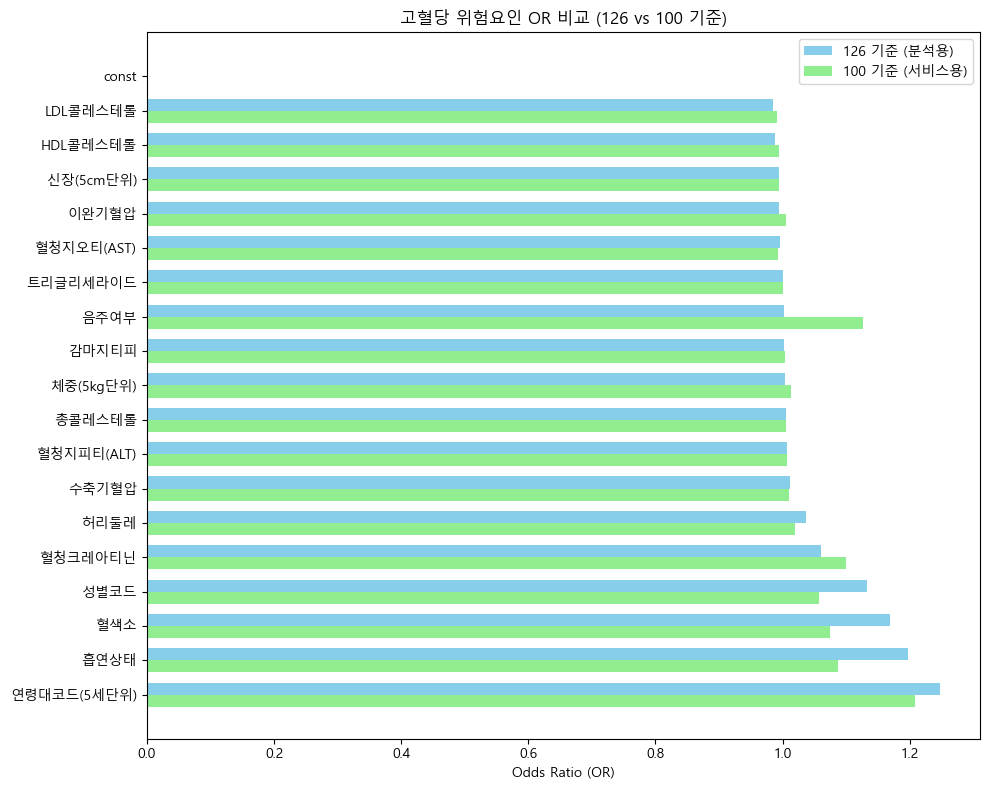

In [24]:

merged = summary_126[['변수','OR (exp(β))']].merge(
    summary_100[['변수','OR (exp(β))']],
    on='변수',
    suffixes=('_126','_100')
)


merged = merged.sort_values('OR (exp(β))_126', ascending=False)


plt.figure(figsize=(10,8))
bar_width = 0.35
x = range(len(merged))

plt.barh([i+bar_width for i in x], merged['OR (exp(β))_126'], 
         height=bar_width, label='126 기준 (분석용)', color='skyblue')
plt.barh(x, merged['OR (exp(β))_100'], 
         height=bar_width, label='100 기준 (서비스용)', color='lightgreen')

plt.yticks([i+bar_width/2 for i in x], merged['변수'])
plt.xlabel("Odds Ratio (OR)")
plt.title("고혈당 위험요인 OR 비교 (126 vs 100 기준)")
plt.legend()
plt.tight_layout()
plt.show()

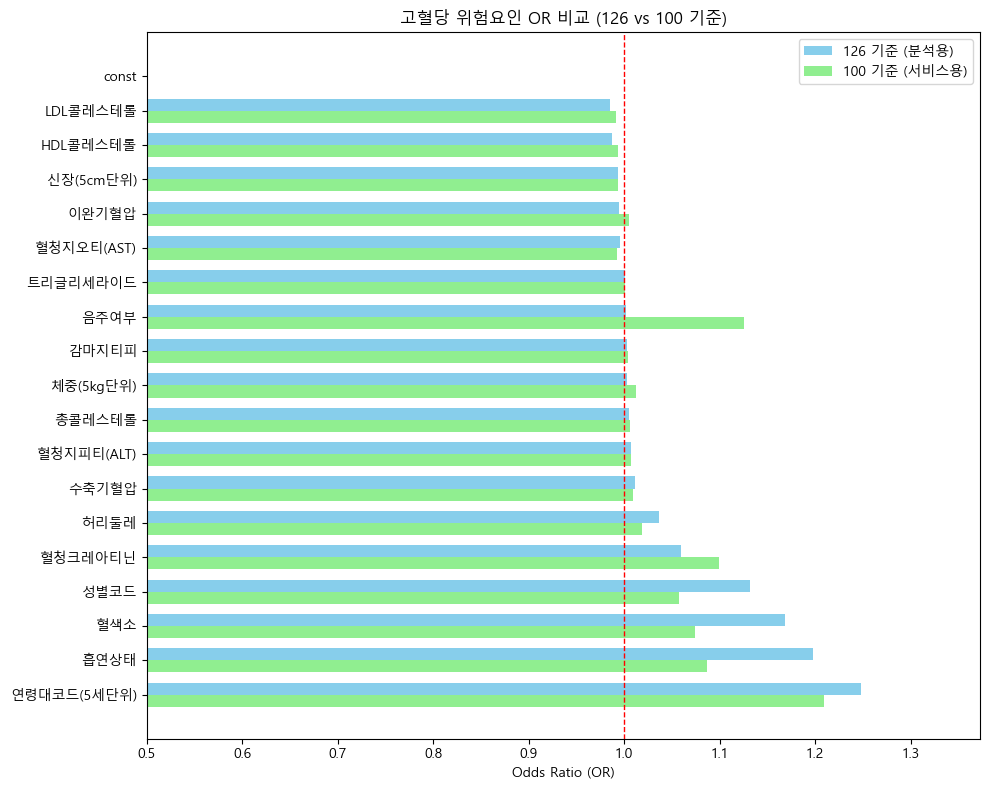

In [26]:
plt.figure(figsize=(10,8))
bar_width = 0.35
x = range(len(merged))

plt.barh([i+bar_width for i in x], merged['OR (exp(β))_126'], 
         height=bar_width, label='126 기준 (분석용)', color='skyblue')
plt.barh(x, merged['OR (exp(β))_100'], 
         height=bar_width, label='100 기준 (서비스용)', color='lightgreen')

# y축 라벨
plt.yticks([i+bar_width/2 for i in x], merged['변수'])

# OR=1 기준선 (점선)
plt.axvline(x=1, color="red", linestyle="--", linewidth=1)

# x축 범위: 0.5부터 시작
plt.xlim(0.5, merged[['OR (exp(β))_126','OR (exp(β))_100']].max().max() * 1.1)

plt.xlabel("Odds Ratio (OR)")
plt.title("고혈당 위험요인 OR 비교 (126 vs 100 기준)")
plt.legend()
plt.tight_layout()
plt.show()


# 인사이트 정리

1. **나이(연령대코드)**는 두 기준 모두에서 가장 강력한 위험요인
OR이 1.2 이상으로 다른 변수들보다 확연히 큼.
즉, 연령이 증가할수록 혈당 이상 확률이 크게 높아짐.
따라서 서비스에서는 나이대별 맞춤 관리 기능을 제공하면 신뢰도가 높아짐. (예: 20대 예방 → 50대 이후 집중 관리)

2. 허리둘레·혈압·간 수치(ALT, AST, 감마GTP) 역시 일관된 위험 요인
생활습관(운동 부족, 복부비만, 음주)과 연결.
즉, 사용자가 체중·허리둘레·혈압만 입력해도 고위험군 예측 가능.
실측데이터가 없는 일반인 자가테스트용으로 활용하기 딱 좋음.

3. 콜레스테롤 계열 변수의 방향성 차이
LDL, HDL은 OR<1 → 고혈당과 역상관 (높으면 오히려 보호 효과로 나타남).
하지만 총콜레스테롤은 OR>1로 약간 위험요인.
사용자에게 단순히 "콜레스테롤 높다=위험"이 아니라, LDL/HDL 균형을 강조하는 교육적 기능을 넣는 게 좋음.

4. 생활습관 요인(흡연·음주)의 민감도 차이
126 기준: 음주효과(OR≈1.00) → 영향이 크지 않음.
100 기준: 음주 OR=1.12 → 서비스용에서 음주 영향이 두드러짐.
일반인 눈높이에서는 "음주가 혈당 관리에 나쁘다"는 메시지가 설득력 있게 전달됨.
분석용(의학적 기준)에서는 상대적으로 음주보다는 나이·복부비만이 핵심.

5. 체중은 기준에 따라 해석 달라짐

126 기준: 체중 OR=1.003 → 거의 영향 없음.

100 기준: 체중 OR=1.013 → 통계적으로 의미 있음.

체중은 **고혈당 위험을 민감하게 보는 사용자 기준(100)**에서는 강조할 수 있음.
즉, "체중 5kg 늘면 위험이 조금씩 증가"라는 생활 친화형 메시지 가능.



## 1. 타깃 변수 생성

126 이상 → 고혈당_분석용 (학술·의학 기준)

100 이상 → 고혈당_서비스용 (사용자 위험 신호 기준)

## 2. 설명 변수 준비

신체지표: 연령, 신장, 체중, 허리둘레

혈압/혈액/지질: 혈압, 콜레스테롤, 혈색소, 간·신장 관련 수치

생활습관: 성별, 흡연, 음주

## 3. 전처리

결측치 처리:

수치형 → 중앙값 대체

범주형 → 최빈값 대체

범주형 인코딩: 성별·흡연·음주 → 더미변수(dummy variable) 처리

## 4. 로지스틱 회귀 분석

run_logit() 함수 정의 → β(회귀계수), OR(오즈비), p-value 자동 계산

126 기준 모델과 100 기준 모델을 각각 학습

## 5. 결과 활용

p-value → 유의한 변수 선별

OR(오즈비) → 변수별 위험도 해석

자가 테스트/예상 혈당 모델 설계 근거로 사용 가능

In [8]:
def calculate_risk(age_code=None, waist=None, sex=None,
                   ldl=None, tg=None, gtp=None, smoke=None,
                   hb=None, drink=None, survey_mode=False):
    """
    age_code: 5세 단위 연령코드 (예: 8=40대, 10=50대)
    waist: 허리둘레(cm)
    sex: 1=남, 2=여
    ldl: LDL 콜레스테롤
    tg: 트리글리세라이드
    gtp: 감마지티피
    smoke: 0=비흡연, 2=과거흡연, 3=현재흡연
    hb: 혈색소
    drink: 0=비음주, 1=음주
    survey_mode: True면 설문 모드(자가 응답 기반), False면 검진 데이터 기반
    """
    score = 0
    
    
    if age_code:
        if age_code >= 10: score += 2   
        elif age_code >= 8: score += 1  

    
    if waist and sex:
        if (sex == 1 and waist >= 90) or (sex == 2 and waist >= 85):
            score += 3

    
    if ldl:
        if ldl >= 160: score += 2
        elif ldl >= 130: score += 1
    elif survey_mode:  
        score += 1

    
    if tg:
        if tg >= 200: score += 2
        elif tg >= 150: score += 1
    elif survey_mode:  
        score += 1

    
    if gtp:
        if gtp >= 70: score += 2
        elif gtp >= 40: score += 1
    elif survey_mode:  
        score += 1

    
    if smoke == 3: score += 2
    elif smoke == 2: score += 1

    
    if hb and sex:
        if (sex == 1 and hb > 17) or (sex == 2 and hb > 15.5):
            score += 1

    
    if drink == 1: score += 1

    
    if score >= 7:
        level = "위험"
    elif score >= 4:
        level = "경고"
    else:
        level = "주의"

    return score, level


In [9]:
survey_dict = {
    "version": "1.0",
    "title": "혈당 자가 위험도 테스트",
    "sections": [
        {
            "id": "basic",
            "title": "기본 정보",
            "fields": [
                {
                    "id": "age_code",
                    "label": "연령대",
                    "type": "select",
                    "options": [
                        {"label": "20-39세", "value": 6},
                        {"label": "40-49세", "value": 8},
                        {"label": "50세 이상", "value": 10}
                    ]
                },
                {
                    "id": "sex",
                    "label": "성별",
                    "type": "radio",
                    "options": [
                        {"label": "남성", "value": 1},
                        {"label": "여성", "value": 2}
                    ]
                },
                {
                    "id": "waist",
                    "label": "허리둘레(cm)",
                    "type": "number",
                    "optional": True
                }
            ]
        },
        {
            "id": "lifestyle",
            "title": "생활습관",
            "fields": [
                {
                    "id": "smoke",
                    "label": "흡연 여부",
                    "type": "radio",
                    "options": [
                        {"label": "비흡연", "value": 0},
                        {"label": "과거 흡연", "value": 2},
                        {"label": "현재 흡연", "value": 3}
                    ]
                },
                {
                    "id": "drink",
                    "label": "음주 여부",
                    "type": "radio",
                    "options": [
                        {"label": "아니오", "value": 0},
                        {"label": "예", "value": 1}
                    ]
                }
            ]
        },
        {
            "id": "symptoms",
            "title": "혈당 이상 증상 체크리스트",
            "fields": [
                {
                    "id": "thirst",
                    "label": "목이 자주 마르고 물을 많이 마신다",
                    "type": "radio",
                    "options": [
                        {"label": "예", "value": 1},
                        {"label": "아니오", "value": 0}
                    ]
                },
                {
                    "id": "urination",
                    "label": "소변을 평소보다 자주 본다",
                    "type": "radio",
                    "options": [
                        {"label": "예", "value": 1},
                        {"label": "아니오", "value": 0}
                    ]
                },
                {
                    "id": "fatigue",
                    "label": "피로감이 쉽게 온다",
                    "type": "radio",
                    "options": [
                        {"label": "예", "value": 1},
                        {"label": "아니오", "value": 0}
                    ]
                }
            ]
        },
        {
            "id": "lab",
            "title": "건강검진 수치 (선택 입력)",
            "fields": [
                {"id": "ldl", "label": "LDL 콜레스테롤 (mg/dL)", "type": "number", "optional": True},
                {"id": "tg", "label": "트리글리세라이드 (mg/dL)", "type": "number", "optional": True},
                {"id": "gtp", "label": "감마지티피 (U/L)", "type": "number", "optional": True},
                {"id": "hb", "label": "혈색소 (g/dL)", "type": "number", "optional": True}
            ]
        }
    ],
    "submit": {
        "label": "위험도 계산하기",
        "action": "/api/calculate_risk"
    }
}

print(survey_dict["title"])
for sec in survey_dict["sections"]:
    print(f"- {sec['title']} ({len(sec['fields'])}개 질문)")


혈당 자가 위험도 테스트
- 기본 정보 (3개 질문)
- 생활습관 (2개 질문)
- 혈당 이상 증상 체크리스트 (3개 질문)
- 건강검진 수치 (선택 입력) (4개 질문)


In [10]:
def risk_score(row):
    score = 0
    
    # 1. 연령
    if row['연령대코드(5세단위)'] >= 10:   
        score += 2
    elif row['연령대코드(5세단위)'] >= 8:  
        score += 1

    # 2. 허리둘레
    if (row['성별코드'] == 1 and row['허리둘레'] >= 90) or (row['성별코드'] == 2 and row['허리둘레'] >= 85):
        score += 3

    # 3. LDL
    if row['LDL콜레스테롤'] >= 160:
        score += 2
    elif row['LDL콜레스테롤'] >= 130:
        score += 1

    # 4. 중성지방(TG)
    if row['트리글리세라이드'] >= 200:
        score += 2
    elif row['트리글리세라이드'] >= 150:
        score += 1

    # 5. 감마지티피
    if row['감마지티피'] >= 70:
        score += 2
    elif row['감마지티피'] >= 40:
        score += 1

    # 6. 흡연
    if row['흡연상태'] == 3.0:
        score += 2
    elif row['흡연상태'] == 2.0:
        score += 1

    # 7. 혈색소
    if (row['성별코드'] == 1 and row['혈색소'] > 17) or (row['성별코드'] == 2 and row['혈색소'] > 15.5):
        score += 1

    # 8. 음주
    if row['음주여부'] == 1.0:
        score += 1

    # 9. 증상 체크리스트 (예=1, 아니오=0 가정)
    if '증상_갈증' in row and row['증상_갈증'] == 1:
        score += 1
    if '증상_다뇨' in row and row['증상_다뇨'] == 1:
        score += 1
    if '증상_피로' in row and row['증상_피로'] == 1:
        score += 1

    return score



def risk_level(score):
    if score >= 7:
        return "위험"
    elif score >= 4:
        return "경고"
    else:
        return "주의"

df['risk_score'] = df.apply(risk_score, axis=1)
df['risk_level'] = df['risk_score'].apply(risk_level)

print(df[['연령대코드(5세단위)','허리둘레','LDL콜레스테롤','트리글리세라이드','감마지티피','흡연상태','혈색소','음주여부','risk_score','risk_level']].head(20))


    연령대코드(5세단위)  허리둘레  LDL콜레스테롤  트리글리세라이드  감마지티피  흡연상태   혈색소  음주여부  \
0            13  70.0     113.0     105.0    6.0   1.0  14.7   1.0   
1            11  74.9     113.0     105.0   14.0   1.0  12.7   1.0   
2            13  74.0     113.0     105.0   17.0   1.0  13.7   1.0   
3            16  89.0     113.0     105.0   28.0   1.0  15.6   1.0   
4            11  76.0     113.0     105.0   12.0   1.0  14.8   1.0   
5            10  90.0     113.0     105.0   38.0   1.0  14.8   1.0   
6            11  78.0     113.0     105.0   40.0   1.0  15.1   1.0   
7             9  77.0     113.0     105.0   18.0   1.0  14.6   1.0   
8            10  82.5     113.0     105.0   37.0   1.0  15.9   1.0   
9            10  87.0     113.0     105.0   16.0   1.0  14.9   1.0   
10           13  87.0     113.0     105.0   24.0   1.0  15.5   0.0   
11            9  76.5     113.0     105.0   11.0   1.0  13.2   1.0   
12            7  70.4     113.0     105.0   10.0   1.0  13.0   0.0   
13            5  73.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
target = "고혈당_분석용"   
y = df[target]


exclude_cols = [
    "고혈당_분석용", "고혈당_서비스용", "식전혈당(공복혈당)",
    "risk_level" 
]

X = df.drop(columns=exclude_cols, errors="ignore")


cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


X = X.astype("float32")
y = y.astype("int")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")


xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale
)

xgb_model.fit(X_train, y_train)


print("📊 XGBoost (class weight 적용)")
print(classification_report(y_test, xgb_model.predict(X_test)))


scale_pos_weight = 11.76
📊 XGBoost (class weight 적용)
              precision    recall  f1-score   support

           0       0.97      0.69      0.81    184213
           1       0.18      0.79      0.29     15787

    accuracy                           0.70    200000
   macro avg       0.58      0.74      0.55    200000
weighted avg       0.91      0.70      0.77    200000



# 자가 테스트 문항/점수 체계를 데이터적으로 검증

📊 변수 중요도 (XGBoost)
             변수    중요도(gain)
25   risk_score  1125.184082
2   연령대코드(5세단위)   647.318542
29     음주여부_1.0   486.763977
17          요단백   239.532654
5          허리둘레   210.922867
26       성별코드_2   194.604980
21        감마지티피   171.865433
15     LDL콜레스테롤   161.903244
20   혈청지피티(ALT)   129.434189
19   혈청지오티(AST)   125.716179
12       총콜레스테롤   121.539520
18      혈청크레아티닌   110.883232
16          혈색소    96.447632
7         시력(우)    85.975998
6         시력(좌)    80.277061
10        수축기혈압    79.446793
13     트리글리세라이드    78.637581
28     흡연상태_3.0    67.040977
23      치아우식증유무    64.382401
11        이완기혈압    55.289452


<Figure size 1000x600 with 0 Axes>

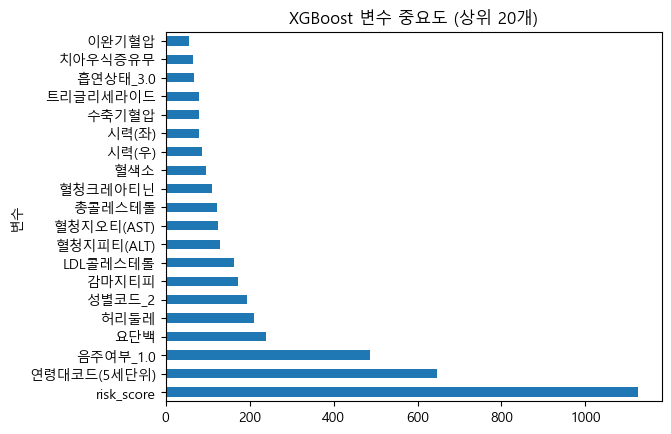

In [12]:

importance = xgb_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    '변수': list(importance.keys()),
    '중요도(gain)': list(importance.values())
}).sort_values(by='중요도(gain)', ascending=False)

print("📊 변수 중요도 (XGBoost)")
print(importance_df.head(20))

plt.figure(figsize=(10,6))
importance_df.head(20).plot(
    kind='barh', x='변수', y='중요도(gain)', legend=False
)
plt.title("XGBoost 변수 중요도 (상위 20개)")
plt.show()


## 인사이트 해석

risk_score가 압도적

risk_score가 1125로 가장 높음 → 우리가 만든 자가진단용 점수가 모델에서 가장 강력한 예측 변수로 작동했다는 의미.

즉, 웹 서비스에서 자가테스트 기능을 제공하는 게 실제 예측 성능에도 근거가 있다는 걸 보여줌.

연령·허리둘레·성별 → 고전적 위험요인

연령대, 허리둘레, 성별이 상위권.

이건 의학적 근거와도 일치 → 나이 많을수록, 복부 비만일수록, 남성일수록 고혈당 위험 ↑.

사용자가 쉽게 이해할 수 있는 "생활 기반 위험 인자"라서 설문 항목으로 쓰기 좋음.

음주, 흡연도 상위 요인

음주여부, 흡연상태가 변수 중요도 상위권에 등장.

웹사이트 자가테스트에 포함시켜서 행동 변화 유도 메시지 줄 수 있음 ("금주·금연이 혈당 관리에 큰 영향").

임상 검사치들도 영향력 큼

LDL콜레스테롤, 감마지티피, 트리글리세라이드, 혈청지오티(AST/ALT), 혈청크레아티닌 등.

즉, 혈당만 보지 않고 대사증후군 관련 전체 프로파일이 중요하다는 걸 보여줌.

건강검진 입력을 받는다면 추가적으로 반영 가능.

의외의 요인 → 시력, 치아우식증

시력(좌/우)와 치아우식증유무도 모델이 잡아냈음.

직접적 연관은 약하지만, 전신 건강지표나 생활습관과 연관되어서 신호로 쓰였을 가능성.

인과성보다는 데이터에서 패턴을 잡은 결과로 해석.

In [13]:

target = "고혈당_분석용"  
y = df[target]


exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]
X = df.drop(columns=exclude_cols, errors="ignore")


cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")



from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale
)

xgb_model.fit(X_train, y_train)


print("📊 XGBoost (class weight 적용)")
print(classification_report(y_test, xgb_model.predict(X_test)))


scale_pos_weight = 11.76
📊 XGBoost (class weight 적용)
              precision    recall  f1-score   support

           0       0.97      0.69      0.81    184213
           1       0.18      0.79      0.29     15787

    accuracy                           0.70    200000
   macro avg       0.58      0.74      0.55    200000
weighted avg       0.91      0.70      0.77    200000



이 모델은 “고혈당 위험 예측기” 역할 → 사용자 입력(검진/설문 기반 변수)으로 고혈당 여부를 분류
평가 결과에서 **재현율(recall)**이 중요 → 실제 고혈당 환자를 놓치지 않는지 확인하는 지표

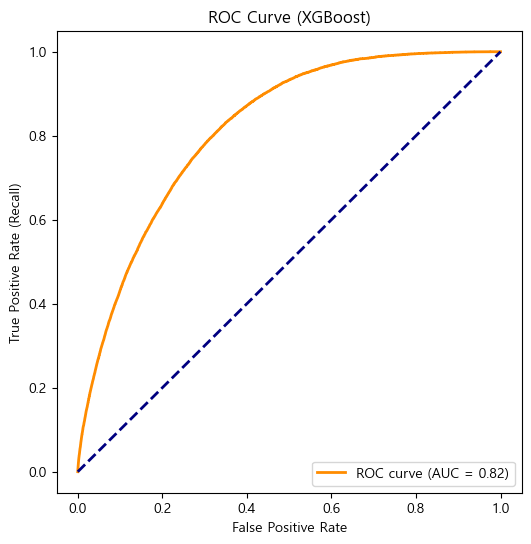

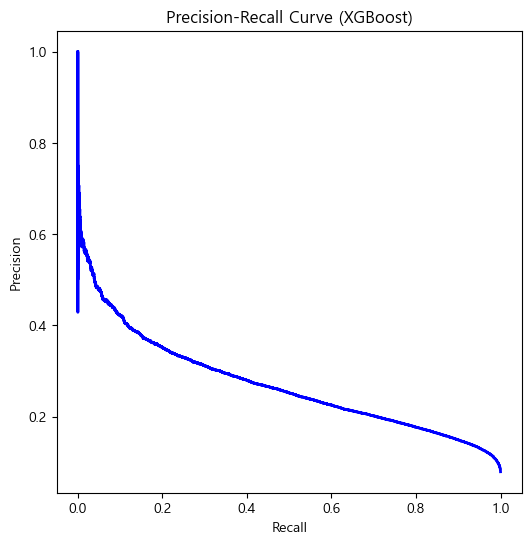

✅ 최적 Threshold = 0.69
Precision = 0.26, Recall = 0.47, F1 = 0.34


In [14]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve


y_proba = xgb_model.predict_proba(X_test)[:, 1] 


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (XGBoost)")
plt.legend(loc="lower right")
plt.show()


prec, rec, pr_thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(rec, prec, color='blue', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.show()


f1_scores = 2 * (prec * rec) / (prec + rec)
best_idx = f1_scores.argmax()
best_threshold = pr_thresholds[best_idx]

print(f"✅ 최적 Threshold = {best_threshold:.2f}")
print(f"Precision = {prec[best_idx]:.2f}, Recall = {rec[best_idx]:.2f}, F1 = {f1_scores[best_idx]:.2f}")


scale_pos_weight = 11.76
ROC-AUC = 0.82


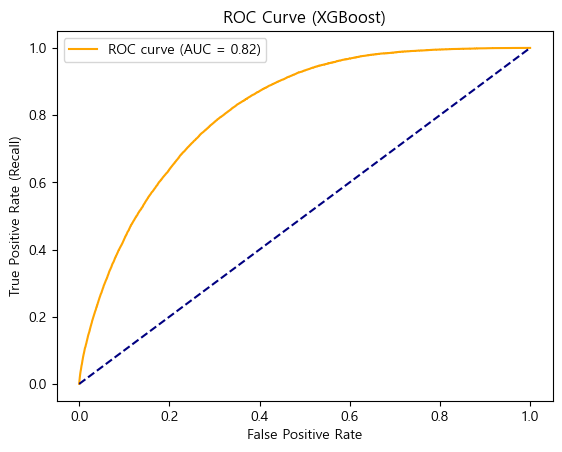

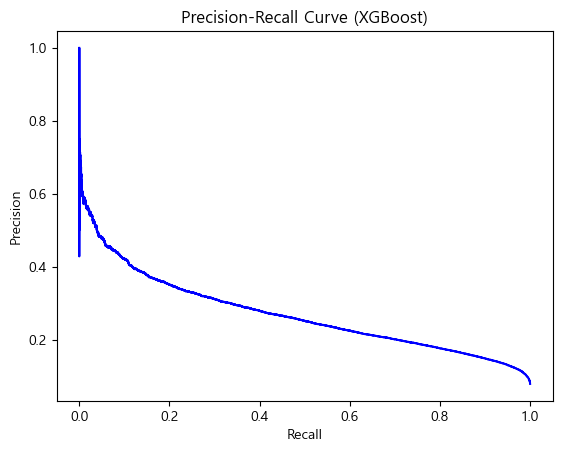

✅ 최적 Threshold = 0.69
📊 XGBoost (Threshold 조정)
              precision    recall  f1-score   support

           0       0.95      0.88      0.92    184213
           1       0.26      0.47      0.34     15787

    accuracy                           0.85    200000
   macro avg       0.61      0.68      0.63    200000
weighted avg       0.90      0.85      0.87    200000



In [15]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

from xgboost import XGBClassifier

target = "고혈당_분석용"   
y = df[target]

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]
X = df.drop(columns=exclude_cols, errors="ignore")


cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


X = X.astype("float32")
y = y.astype("int")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")


xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale
)

xgb_model.fit(X_train, y_train)


y_pred_proba = xgb_model.predict_proba(X_test)[:,1]


auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC = {auc:.2f}")


fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color="orange", label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0,1],[0,1],"--",color="navy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (XGBoost)")
plt.legend()
plt.show()


prec, rec, thresh = precision_recall_curve(y_test, y_pred_proba)
plt.plot(rec, prec, color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.show()


best_thresh = thresh[np.argmax(2*prec*rec/(prec+rec+1e-6))]  # F1 최대 기준
print(f"✅ 최적 Threshold = {best_thresh:.2f}")


y_pred_custom = (y_pred_proba >= best_thresh).astype(int)

print("📊 XGBoost (Threshold 조정)")
print(classification_report(y_test, y_pred_custom))


In [16]:
!pip install lightgbm

scale_pos_weight ≈ 11.76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62685, number of negative: 737315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2799
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
ROC-AUC = 0.82


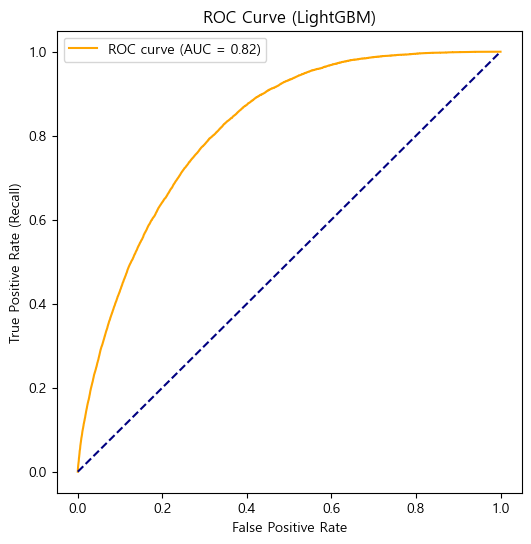

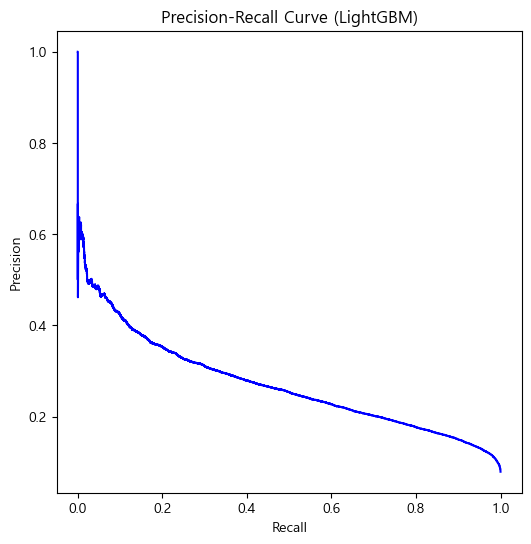

✅ 최적 Threshold = 0.70
Precision = 0.26, Recall = 0.49, F1 = 0.34
📊 LightGBM (Threshold 조정)
              precision    recall  f1-score   support

           0       0.95      0.88      0.91    184213
           1       0.26      0.49      0.34     15787

    accuracy                           0.85    200000
   macro avg       0.60      0.68      0.63    200000
weighted avg       0.90      0.85      0.87    200000


📊 변수 중요도 (LightGBM 상위 20)
             변수  중요도
20   혈청지오티(AST)  751
17          혈색소  719
21   혈청지피티(ALT)  647
3   연령대코드(5세단위)  643
22        감마지티피  624
19      혈청크레아티닌  569
6          허리둘레  538
11        수축기혈압  438
12        이완기혈압  418
16     LDL콜레스테롤  411
14     트리글리세라이드  398
13       총콜레스테롤  339
18          요단백  289
5     체중(5kg단위)  283
29   risk_score  269
1       가입자일련번호  241
2          시도코드  229
4     신장(5cm단위)  202
15     HDL콜레스테롤  183
8         시력(우)  182


<Figure size 1000x600 with 0 Axes>

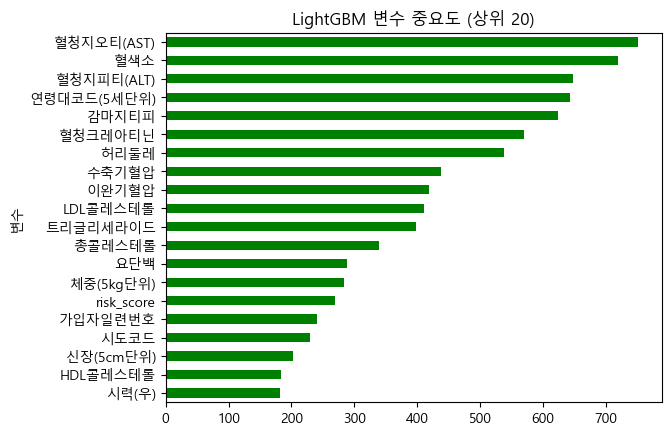

In [17]:

target = "고혈당_분석용"   
y = df[target]

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]
X = df.drop(columns=exclude_cols, errors="ignore")


cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


X = X.astype("float32")
y = y.astype("int")


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f"scale_pos_weight ≈ {scale:.2f}")


from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

lgb_model = LGBMClassifier(
    n_estimators=300,
    max_depth=-1,              
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight={0:1, 1:scale}  
)

lgb_model.fit(X_train, y_train)


y_pred_proba = lgb_model.predict_proba(X_test)[:,1]


auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC = {auc:.2f}")


fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="orange", label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1],[0,1],"--",color="navy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (LightGBM)")
plt.legend()
plt.show()


prec, rec, thresh = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(rec, prec, color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (LightGBM)")
plt.show()


f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = np.argmax(f1_scores)
best_thresh = thresh[best_idx]

print(f"✅ 최적 Threshold = {best_thresh:.2f}")
print(f"Precision = {prec[best_idx]:.2f}, Recall = {rec[best_idx]:.2f}, F1 = {f1_scores[best_idx]:.2f}")


y_pred_custom = (y_pred_proba >= best_thresh).astype(int)

print("📊 LightGBM (Threshold 조정)")
print(classification_report(y_test, y_pred_custom))


importance_df = pd.DataFrame({
    "변수": X.columns,
    "중요도": lgb_model.feature_importances_
}).sort_values(by="중요도", ascending=False)

print("\n📊 변수 중요도 (LightGBM 상위 20)")
print(importance_df.head(20))

plt.figure(figsize=(10,6))
importance_df.head(20).plot(
    kind="barh", x="변수", y="중요도", legend=False, color="green"
)
plt.title("LightGBM 변수 중요도 (상위 20)")
plt.gca().invert_yaxis()
plt.show()


scale_pos_weight ≈ 11.76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62685, number of negative: 737315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2799
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
ROC-AUC = 0.82


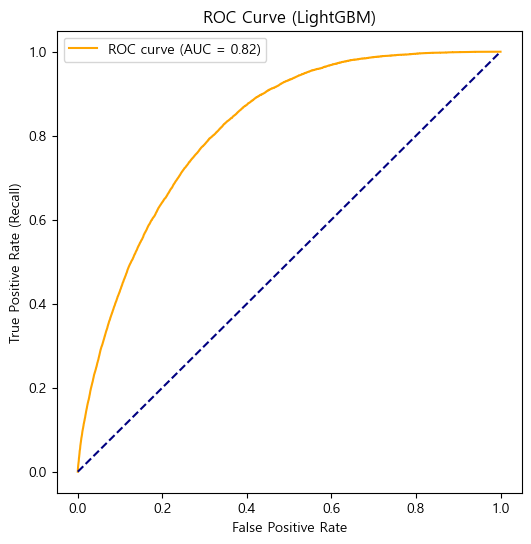

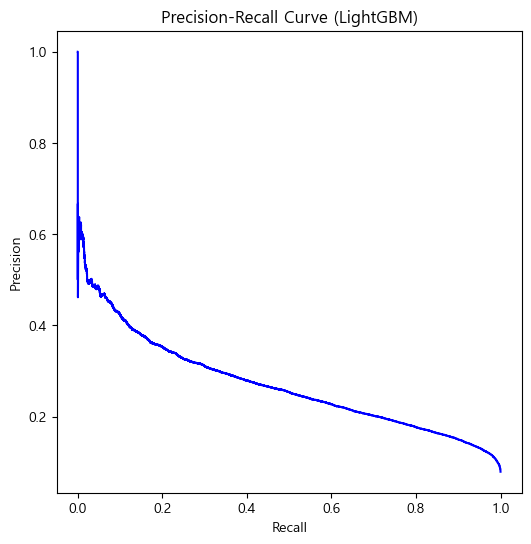

✅ 최적 Threshold = 0.70
Precision = 0.26, Recall = 0.49, F1 = 0.34
📊 LightGBM (Threshold 조정)
              precision    recall  f1-score   support

           0       0.95      0.88      0.91    184213
           1       0.26      0.49      0.34     15787

    accuracy                           0.85    200000
   macro avg       0.60      0.68      0.63    200000
weighted avg       0.90      0.85      0.87    200000



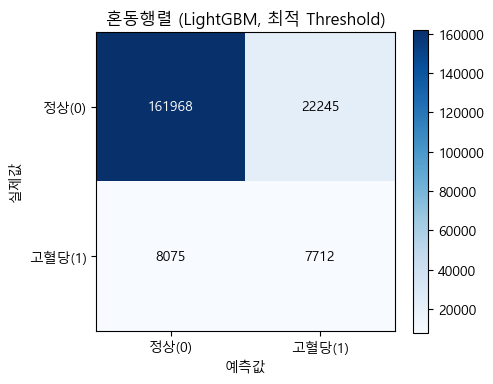


📊 변수 중요도 (LightGBM 상위 20)
             변수  중요도
20   혈청지오티(AST)  751
17          혈색소  719
21   혈청지피티(ALT)  647
3   연령대코드(5세단위)  643
22        감마지티피  624
19      혈청크레아티닌  569
6          허리둘레  538
11        수축기혈압  438
12        이완기혈압  418
16     LDL콜레스테롤  411
14     트리글리세라이드  398
13       총콜레스테롤  339
18          요단백  289
5     체중(5kg단위)  283
29   risk_score  269
1       가입자일련번호  241
2          시도코드  229
4     신장(5cm단위)  202
15     HDL콜레스테롤  183
8         시력(우)  182


<Figure size 1000x600 with 0 Axes>

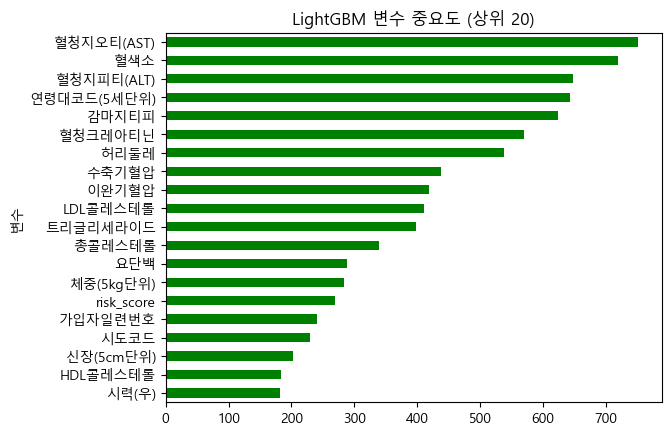

In [18]:

target = "고혈당_분석용"  
y = df[target]

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]
X = df.drop(columns=exclude_cols, errors="ignore")


cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


X = X.astype("float32")
y = y.astype("int")


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f"scale_pos_weight ≈ {scale:.2f}")


from lightgbm import LGBMClassifier
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve,
                             precision_recall_curve, accuracy_score,
                             precision_score, recall_score, f1_score,
                             confusion_matrix)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

lgb_model = LGBMClassifier(
    n_estimators=300,
    max_depth=-1,              
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight={0:1, 1:scale}  
)

lgb_model.fit(X_train, y_train)


y_pred_proba = lgb_model.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC = {auc:.2f}")


fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="orange", label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1],[0,1],"--",color="navy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (LightGBM)")
plt.legend()
plt.show()


prec, rec, thresh = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(rec, prec, color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (LightGBM)")
plt.show()


f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = np.argmax(f1_scores)
best_thresh = thresh[best_idx]

print(f"✅ 최적 Threshold = {best_thresh:.2f}")
print(f"Precision = {prec[best_idx]:.2f}, Recall = {rec[best_idx]:.2f}, F1 = {f1_scores[best_idx]:.2f}")

y_pred_best = (y_pred_proba >= best_thresh).astype(int)

print("📊 LightGBM (Threshold 조정)")
print(classification_report(y_test, y_pred_best))


cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("혼동행렬 (LightGBM, 최적 Threshold)")
plt.colorbar()


classes = ["정상(0)", "고혈당(1)"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)


thresh_val = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh_val else "black")

plt.ylabel("실제값")
plt.xlabel("예측값")
plt.tight_layout()
plt.show()


importance_df = pd.DataFrame({
    "변수": X.columns,
    "중요도": lgb_model.feature_importances_
}).sort_values(by="중요도", ascending=False)

print("\n📊 변수 중요도 (LightGBM 상위 20)")
print(importance_df.head(20))

plt.figure(figsize=(10,6))
importance_df.head(20).plot(
    kind="barh", x="변수", y="중요도", legend=False, color="green"
)
plt.title("LightGBM 변수 중요도 (상위 20)")
plt.gca().invert_yaxis()
plt.show()


In [19]:
user_input = {
    "연령대코드(5세단위)": 10,
    "성별코드": 1,
    "허리둘레": 92,
    "LDL콜레스테롤": 150,
    "트리글리세라이드": 180,
    "감마지티피": 55,
    "흡연상태": 2.0,
    "혈색소": 16.5,
    "음주여부": 1.0
}

# ✅ DataFrame으로 변환 (1행짜리)
user_df = pd.DataFrame([user_input])

# ✅ 학습 때 했던 전처리 동일하게 적용
cat_cols = ["성별코드","흡연상태","음주여부"]
user_df = pd.get_dummies(user_df, columns=cat_cols, drop_first=True)

# 학습된 X의 컬럼과 동일하게 맞추기 (없는 컬럼은 0으로 채움)
for col in X.columns:
    if col not in user_df.columns:
        user_df[col] = 0
user_df = user_df[X.columns]  # 순서도 맞추기

# ✅ 예측 확률
proba = lgb_model.predict_proba(user_df)[:,1][0]
pred = (proba >= 0.5).astype(int)

print(f"사용자 고혈당 위험 확률: {proba*100:.1f}%")
print("분류 결과:", "고혈당 위험 🚨" if pred==1 else "정상 🟢")

사용자 고혈당 위험 확률: 75.4%
분류 결과: 고혈당 위험 🚨


In [20]:
import pandas as pd
import numpy as np

# ==========================
# 1. 체크리스트 기반 위험도
# ==========================
def risk_score_from_input(user):
    score = 0
    
    # 연령
    if user["연령대코드(5세단위)"] >= 10:
        score += 2
    elif user["연령대코드(5세단위)"] >= 8:
        score += 1

    # 허리둘레
    if (user["성별코드"] == 1 and user["허리둘레"] >= 90) or (user["성별코드"] == 2 and user["허리둘레"] >= 85):
        score += 3

    # LDL
    if user["LDL콜레스테롤"] >= 160:
        score += 2
    elif user["LDL콜레스테롤"] >= 130:
        score += 1

    # TG
    if user["트리글리세라이드"] >= 200:
        score += 2
    elif user["트리글리세라이드"] >= 150:
        score += 1

    # GTP
    if user["감마지티피"] >= 70:
        score += 2
    elif user["감마지티피"] >= 40:
        score += 1

    # 흡연
    if user["흡연상태"] == 3.0:
        score += 2
    elif user["흡연상태"] == 2.0:
        score += 1

    # 혈색소
    if (user["성별코드"] == 1 and user["혈색소"] > 17) or (user["성별코드"] == 2 and user["혈색소"] > 15.5):
        score += 1

    # 음주
    if user["음주여부"] == 1.0:
        score += 1

    # 증상 체크리스트
    symptoms = user.get("증상", {})
    for s, has_symptom in symptoms.items():
        if has_symptom:
            score += 1

    return score


def risk_level(score):
    if score >= 7:
        return "🚨 위험"
    elif score >= 4:
        return "⚠️ 경고"
    else:
        return "🟢 주의"


# ==========================
# 2. 머신러닝 기반 예측
# ==========================
def ml_predict(user, model, X_columns):
    user_df = pd.DataFrame([user])
    
    # 카테고리 변수 인코딩
    cat_cols = ["성별코드","흡연상태","음주여부"]
    user_df = pd.get_dummies(user_df, columns=cat_cols, drop_first=True)

    # 학습 때 사용한 컬럼과 맞추기
    for col in X_columns:
        if col not in user_df.columns:
            user_df[col] = 0
    user_df = user_df[X_columns]

    # 예측
    proba = model.predict_proba(user_df)[:,1][0]
    return proba


# 머신러닝 확률 → 위험 등급 변환
def ml_risk_level(proba):
    if proba >= 0.7:
        return "🚨 위험"
    elif proba >= 0.4:
        return "⚠️ 경고"
    else:
        return "🟢 주의"


# ==========================
# 3. 실행 예시
# ==========================
user_input = {
    "연령대코드(5세단위)": 10,
    "성별코드": 1,
    "허리둘레": 92,
    "LDL콜레스테롤": 150,
    "트리글리세라이드": 180,
    "감마지티피": 55,
    "흡연상태": 2.0,
    "혈색소": 16.5,
    "음주여부": 1.0,
    "증상": {
        "갈증": True,
        "잦은소변": False,
        "피로감": True,
        "체중감소": False,
        "시야흐림": True
    }
}

# ✅ 1. 체크리스트 기반
score = risk_score_from_input(user_input)
level = risk_level(score)

# ✅ 2. 머신러닝 기반 (lgb_model은 이미 학습된 LightGBM 모델, X.columns는 학습 데이터 컬럼)
proba = ml_predict(user_input, lgb_model, X.columns)
ml_level = ml_risk_level(proba)

# ✅ 출력
print("===== 체크리스트 기반 =====")
print(f"총 점수: {score}")
print(f"위험 등급: {level}")

print("\n===== 머신러닝 기반 (LightGBM) =====")
print(f"고혈당 위험 확률: {proba*100:.1f}%")
print(f"위험 등급: {ml_level}")


===== 체크리스트 기반 =====
총 점수: 13
위험 등급: 🚨 위험

===== 머신러닝 기반 (LightGBM) =====
고혈당 위험 확률: 75.4%
위험 등급: 🚨 위험


In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve

# ===================================
# 1. 체크리스트 기반 위험도
# ===================================
def risk_score_from_input(user):
    score = 0
    
    # 연령
    if user["연령대코드(5세단위)"] >= 10:
        score += 2
    elif user["연령대코드(5세단위)"] >= 8:
        score += 1

    # 허리둘레
    if (user["성별코드"] == 1 and user["허리둘레"] >= 90) or (user["성별코드"] == 2 and user["허리둘레"] >= 85):
        score += 3

    # LDL
    if user["LDL콜레스테롤"] >= 160:
        score += 2
    elif user["LDL콜레스테롤"] >= 130:
        score += 1

    # TG
    if user["트리글리세라이드"] >= 200:
        score += 2
    elif user["트리글리세라이드"] >= 150:
        score += 1

    # GTP
    if user["감마지티피"] >= 70:
        score += 2
    elif user["감마지티피"] >= 40:
        score += 1

    # 흡연
    if user["흡연상태"] == 3.0:
        score += 2
    elif user["흡연상태"] == 2.0:
        score += 1

    # 혈색소
    if (user["성별코드"] == 1 and user["혈색소"] > 17) or (user["성별코드"] == 2 and user["혈색소"] > 15.5):
        score += 1

    # 음주
    if user["음주여부"] == 1.0:
        score += 1

    # 증상 체크리스트
    symptoms = user.get("증상", {})
    for s, has_symptom in symptoms.items():
        if has_symptom:
            score += 1

    return score


def risk_level(score):
    if score >= 7:
        return "🚨 위험"
    elif score >= 4:
        return "⚠️ 경고"
    else:
        return "🟢 주의"


# ===================================
# 2. 머신러닝 기반 예측
# ===================================
def ml_predict(user, model, X_columns):
    user_df = pd.DataFrame([user])
    
    # 카테고리 변수 인코딩
    cat_cols = ["성별코드","흡연상태","음주여부"]
    user_df = pd.get_dummies(user_df, columns=cat_cols, drop_first=True)

    # 학습 때 사용한 컬럼과 맞추기
    for col in X_columns:
        if col not in user_df.columns:
            user_df[col] = 0
    user_df = user_df[X_columns]

    # 예측 확률
    proba = model.predict_proba(user_df)[:,1][0]
    return proba


# ROC Curve 기반으로 최적 threshold 찾기
def find_best_threshold(model, X_val, y_val):
    y_proba = model.predict_proba(X_val)[:,1]
    fpr, tpr, thresh = roc_curve(y_val, y_proba)
    f1_scores = 2 * (tpr * (1-fpr)) / (tpr + (1-fpr) + 1e-6)  # 근사 F1 기반
    best_idx = np.argmax(f1_scores)
    return thresh[best_idx]


# 머신러닝 위험 등급 변환
def ml_risk_level(proba, best_thresh):
    # best_thresh를 "경고 vs 위험" 기준으로 활용
    if proba >= best_thresh + 0.2:   # threshold보다 많이 높으면 위험
        return "🚨 위험"
    elif proba >= best_thresh:       # threshold 근처면 경고
        return "⚠️ 경고"
    else:
        return "🟢 주의"


# ===================================
# 3. 실행 예시
# ===================================
# 테스트 입력 (주의 케이스)
user_input = {
    "연령대코드(5세단위)": 6,   # 20대
    "성별코드": 2,            # 여성
    "허리둘레": 70,
    "LDL콜레스테롤": 100,
    "트리글리세라이드": 80,
    "감마지티피": 20,
    "흡연상태": 0.0,         # 비흡연
    "혈색소": 13.0,
    "음주여부": 0.0,
    "증상": {
        "갈증": False,
        "잦은소변": False,
        "피로감": False,
        "체중감소": False,
        "시야흐림": False
    }
}

# ✅ 체크리스트 기반
score = risk_score_from_input(user_input)
level = risk_level(score)

# ✅ 머신러닝 기반 (lgb_model은 학습된 LightGBM 모델, X_test, y_test는 검증셋)
best_thresh = find_best_threshold(lgb_model, X_test, y_test)
proba = ml_predict(user_input, lgb_model, X.columns)
ml_level = ml_risk_level(proba, best_thresh)

# ✅ 출력
print("===== 체크리스트 기반 =====")
print(f"총 점수: {score}")
print(f"위험 등급: {level}")

print("\n===== 머신러닝 기반 (LightGBM) =====")
print(f"고혈당 위험 확률: {proba*100:.1f}%")
print(f"위험 등급: {ml_level}")


===== 체크리스트 기반 =====
총 점수: 0
위험 등급: 🟢 주의

===== 머신러닝 기반 (LightGBM) =====
고혈당 위험 확률: 4.8%
위험 등급: 🟢 주의


In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier

# -----------------------------
# 데이터 샘플링 (20만 건만)
# -----------------------------
df_sample = df.sample(n=200000, random_state=42)

target = "고혈당_분석용"
y = df_sample[target]

exclude_cols = ["고혈당_분석용", "고혈당_서비스용", "식전혈당(공복혈당)", "risk_level"]
X = df_sample.drop(columns=exclude_cols, errors="ignore")

cat_cols = ["성별코드", "흡연상태", "음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# 결측치 처리 + 스케일링
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()
X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

y = y.astype("int")

# -----------------------------
# 30번 반복 성능 저장용
# -----------------------------
results = {"Logistic": {"acc": [], "f1": [], "auc": []},
           "LightGBM": {"acc": [], "f1": [], "auc": []}}

# -----------------------------
# 30회 반복
# -----------------------------
for seed in range(30):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=seed
    )

    # Logistic Regression
    log_model = LogisticRegression(max_iter=500, solver="liblinear")
    log_model.fit(X_train, y_train)
    y_pred_log = log_model.predict(X_test)
    y_pred_proba_log = log_model.predict_proba(X_test)[:, 1]

    results["Logistic"]["acc"].append(accuracy_score(y_test, y_pred_log))
    results["Logistic"]["f1"].append(f1_score(y_test, y_pred_log))
    results["Logistic"]["auc"].append(roc_auc_score(y_test, y_pred_proba_log))

    # LightGBM (경량화 버전)
    neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
    scale = neg / pos if pos > 0 else 1

    lgb_model = LGBMClassifier(
        n_estimators=100,   # 트리 개수 줄임
        learning_rate=0.1,  # 학습률 높여 속도 개선
        max_depth=6,        # 깊이 제한
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=seed,
        class_weight={0: 1, 1: scale},
        verbose=-1          # 로그 억제
    )
    lgb_model.fit(X_train, y_train)
    y_pred_lgb = lgb_model.predict(X_test)
    y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

    results["LightGBM"]["acc"].append(accuracy_score(y_test, y_pred_lgb))
    results["LightGBM"]["f1"].append(f1_score(y_test, y_pred_lgb))
    results["LightGBM"]["auc"].append(roc_auc_score(y_test, y_pred_proba_lgb))

# -----------------------------
# 평균 성능 출력
# -----------------------------
print("===== Logistic Regression (30회 평균) =====")
print(f"ACC = {np.mean(results['Logistic']['acc']):.3f}")
print(f"F1  = {np.mean(results['Logistic']['f1']):.3f}")
print(f"AUC = {np.mean(results['Logistic']['auc']):.3f}")

print("\n===== LightGBM (30회 평균) =====")
print(f"ACC = {np.mean(results['LightGBM']['acc']):.3f}")
print(f"F1  = {np.mean(results['LightGBM']['f1']):.3f}")
print(f"AUC = {np.mean(results['LightGBM']['auc']):.3f}")
# 최종 입력 변수 목록 확인
print("사용된 피처 개수:", X.shape[1])
print("사용된 피처 목록:", list(X.columns))



C:\Users\OWNER\anaconda3\envs\prophet\lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: ['결손치 유무' '치아마모증유무' '제3대구치(사랑니) 이상']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


===== Logistic Regression (30회 평균) =====
ACC = 0.920
F1  = 0.038
AUC = 0.785

===== LightGBM (30회 평균) =====
ACC = 0.692
F1  = 0.289
AUC = 0.812
사용된 피처 개수: 34
사용된 피처 목록: ['기준년도', '가입자일련번호', '시도코드', '연령대코드(5세단위)', '신장(5cm단위)', '체중(5kg단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌', '혈청지오티(AST)', '혈청지피티(ALT)', '감마지티피', '구강검진수검여부', '치아우식증유무', '결손치 유무', '치아마모증유무', '제3대구치(사랑니) 이상', '치석', 'risk_score', '성별코드_2', '흡연상태_2.0', '흡연상태_3.0', '음주여부_1.0']


In [23]:
print("전체 데이터 건수:", len(df))
print("컬럼 수:", df.shape[1])

전체 데이터 건수: 1000000
컬럼 수: 37


In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# -----------------------------
# 1. 위험 점수 계산 함수
# -----------------------------
def risk_score(row):
    score = 0
    
    # 연령
    if row['연령대코드(5세단위)'] >= 10:   
        score += 2
    elif row['연령대코드(5세단위)'] >= 8:  
        score += 1

    # 허리둘레
    if (row['성별코드'] == 1 and row['허리둘레'] >= 90) or (row['성별코드'] == 2 and row['허리둘레'] >= 85):
        score += 3

    # LDL
    if row['LDL콜레스테롤'] >= 160:
        score += 2
    elif row['LDL콜레스테롤'] >= 130:
        score += 1

    # 트리글리세라이드
    if row['트리글리세라이드'] >= 200:
        score += 2
    elif row['트리글리세라이드'] >= 150:
        score += 1

    # 감마지티피
    if row['감마지티피'] >= 70:
        score += 2
    elif row['감마지티피'] >= 40:
        score += 1

    # 흡연
    if row['흡연상태'] == 3.0:
        score += 2
    elif row['흡연상태'] == 2.0:
        score += 1

    # 혈색소
    if (row['성별코드'] == 1 and row['혈색소'] > 17) or (row['성별코드'] == 2 and row['혈색소'] > 15.5):
        score += 1

    # 음주
    if row['음주여부'] == 1.0:
        score += 1

    return score

def risk_level(score):
    if score >= 7:
        return "🚨 위험"
    elif score >= 4:
        return "⚠️ 경고"
    else:
        return "✅ 주의"

# -----------------------------
# 2. 데이터 준비
# -----------------------------
target = "고혈당_분석용"
y = df[target]

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]
X = df.drop(columns=exclude_cols, errors="ignore")

# 범주형 더미화
cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# 결측치 처리
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)
y = y.astype("int")

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 클래스 불균형 처리
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos if pos > 0 else 1

# -----------------------------
# 3. LightGBM (callbacks 방식)
# -----------------------------
lgb_model = LGBMClassifier(
    n_estimators=1000,     # 충분히 크게 두고
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight={0:1, 1:scale},
    verbose=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[early_stopping(30), log_evaluation(50)]  # 👈 변경
)

# -----------------------------
# 4. 사용자 입력 예시
# -----------------------------
user_input = {
    "연령대코드(5세단위)": 10,   # 50세 이상
    "성별코드": 1,              # 남성
    "허리둘레": 95,
    "LDL콜레스테롤": 170,
    "트리글리세라이드": 180,
    "감마지티피": 45,
    "흡연상태": 3.0,            # 현재흡연
    "혈색소": 16.5,
    "음주여부": 1.0
}
user_df = pd.DataFrame([user_input])

# -----------------------------
# 5. 체크리스트 기반 위험도
# -----------------------------
score = risk_score(user_df.iloc[0])
level = risk_level(score)

print("===== 체크리스트 기반 =====")
print(f"총 점수: {score}")
print(f"위험 등급: {level}")

# -----------------------------
# 6. 머신러닝 기반 위험도
# -----------------------------
user_df_ml = pd.DataFrame([user_input])
user_df_ml = pd.get_dummies(user_df_ml, columns=["성별코드","흡연상태","음주여부"], drop_first=True)

# 누락된 컬럼 맞추기
missing_cols = set(pd.DataFrame(X_train).columns) - set(user_df_ml.columns)
for c in missing_cols:
    user_df_ml[c] = 0
user_df_ml = user_df_ml[pd.DataFrame(X_train).columns]  # 순서 맞추기

# 예측
proba = lgb_model.predict_proba(user_df_ml)[:,1][0]
ml_level = risk_level(int(proba * 10 // 1))  # 확률을 점수처럼 변환해서 등급화

print("\n===== 머신러닝 기반 (LightGBM) =====")
print(f"고혈당 위험 확률: {proba*100:.1f}%")
print(f"위험 등급: {ml_level}")


C:\Users\OWNER\anaconda3\envs\prophet\lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: ['결손치 유무' '치아마모증유무' '제3대구치(사랑니) 이상']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Training until validation scores don't improve for 30 rounds
[50]	valid_0's auc: 0.804888	valid_0's binary_logloss: 0.55155
[100]	valid_0's auc: 0.812761	valid_0's binary_logloss: 0.535123
[150]	valid_0's auc: 0.815853	valid_0's binary_logloss: 0.529644
[200]	valid_0's auc: 0.81686	valid_0's binary_logloss: 0.527026
[250]	valid_0's auc: 0.817339	valid_0's binary_logloss: 0.525229
[300]	valid_0's auc: 0.817544	valid_0's binary_logloss: 0.52373
[350]	valid_0's auc: 0.817691	valid_0's binary_logloss: 0.522315
Early stopping, best iteration is:
[363]	valid_0's auc: 0.817727	valid_0's binary_logloss: 0.521959
===== 체크리스트 기반 =====
총 점수: 12
위험 등급: 🚨 위험

===== 머신러닝 기반 (LightGBM) =====
고혈당 위험 확률: 5.9%
위험 등급: ✅ 주의


In [25]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import pandas as pd
import numpy as np

# -----------------------------
# 공통 전처리
# -----------------------------
exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]

X = df.drop(columns=exclude_cols, errors="ignore")
cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X = X.astype("float32")

# -----------------------------
# 성능 평가 함수
# -----------------------------
def eval_model(y, label_name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 클래스 불균형 보정
    neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
    scale = neg / pos if pos > 0 else 1
    print(f"\n[{label_name}] scale_pos_weight ≈ {scale:.2f}")

    lgb_model = LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        class_weight={0:1, 1:scale},
        n_jobs=-1
    )

    lgb_model.fit(X_train, y_train)
    y_pred_proba = lgb_model.predict_proba(X_test)[:,1]
    y_pred = lgb_model.predict(X_test)

    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC = {auc:.3f}")
    print(classification_report(y_test, y_pred))

    return {
        "라벨": label_name,
        "AUC": auc,
        "정밀도(Precision)": np.round(
            classification_report(y_test, y_pred, output_dict=True)["1"]["precision"], 3
        ),
        "재현율(Recall)": np.round(
            classification_report(y_test, y_pred, output_dict=True)["1"]["recall"], 3
        ),
        "F1": np.round(
            classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"], 3
        )
    }

# -----------------------------
# 두 기준 비교
# -----------------------------
results = []
y1 = df["고혈당_분석용"].astype("int")   # 100 기준
y2 = df["고혈당_서비스용"].astype("int") # 126 기준

results.append(eval_model(y1, "고혈당_분석용 (100 기준)"))
results.append(eval_model(y2, "고혈당_서비스용 (126 기준)"))

# 결과 요약표
results_df = pd.DataFrame(results)
print("\n📊 기준별 성능 비교")
print(results_df)



[고혈당_분석용 (100 기준)] scale_pos_weight ≈ 11.76
ROC-AUC = 0.818
              precision    recall  f1-score   support

           0       0.98      0.68      0.80    184213
           1       0.18      0.80      0.29     15787

    accuracy                           0.69    200000
   macro avg       0.58      0.74      0.54    200000
weighted avg       0.91      0.69      0.76    200000


[고혈당_서비스용 (126 기준)] scale_pos_weight ≈ 1.52
ROC-AUC = 0.746
              precision    recall  f1-score   support

           0       0.78      0.64      0.70    120551
           1       0.57      0.73      0.64     79449

    accuracy                           0.67    200000
   macro avg       0.67      0.68      0.67    200000
weighted avg       0.70      0.67      0.68    200000


📊 기준별 성능 비교
                  라벨       AUC  정밀도(Precision)  재현율(Recall)     F1
0   고혈당_분석용 (100 기준)  0.817689           0.176        0.801  0.289
1  고혈당_서비스용 (126 기준)  0.746499           0.569        0.730  0.639


In [26]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -----------------------------
# 1. 데이터 준비 (100 기준)
# -----------------------------
target = "고혈당_분석용"   # 100 기준
y = df[target].astype("int")

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]
X = df.drop(columns=exclude_cols, errors="ignore")

cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X = X.astype("float32")

# -----------------------------
# 2. train-test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 클래스 불균형 비율
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos if pos > 0 else 1
print(f"scale_pos_weight ≈ {scale:.2f}")

# -----------------------------
# 3. LightGBM 모델 (최적화)
# -----------------------------
lgb_model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight={0:1, 1:scale},
    n_jobs=-1
)

# ✅ callbacks로 early stopping 적용
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[early_stopping(100), log_evaluation(100)]
)

# -----------------------------
# 4. 성능 평가
# -----------------------------
y_pred_proba = lgb_model.predict_proba(X_test)[:,1]

# ROC-AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC = {auc:.3f}")

# 최적 threshold (F1 기준)
prec, rec, thresh = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = np.argmax(f1_scores)
best_thresh = thresh[best_idx]

print(f"✅ 최적 Threshold = {best_thresh:.2f}")
print(f"Precision = {prec[best_idx]:.2f}, Recall = {rec[best_idx]:.2f}, F1 = {f1_scores[best_idx]:.2f}")

# -----------------------------
# 5. 최적 threshold 적용 결과
# -----------------------------
y_pred_best = (y_pred_proba >= best_thresh).astype(int)
print("\n📊 LightGBM (100 기준, 최적 Threshold 적용)")
print(classification_report(y_test, y_pred_best))


scale_pos_weight ≈ 11.76
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.794961	valid_0's binary_logloss: 0.588006
[200]	valid_0's auc: 0.802347	valid_0's binary_logloss: 0.558423
[300]	valid_0's auc: 0.807668	valid_0's binary_logloss: 0.545547
[400]	valid_0's auc: 0.810982	valid_0's binary_logloss: 0.538779
[500]	valid_0's auc: 0.813196	valid_0's binary_logloss: 0.534624
[600]	valid_0's auc: 0.814788	valid_0's binary_logloss: 0.531783
[700]	valid_0's auc: 0.815831	valid_0's binary_logloss: 0.529843
[800]	valid_0's auc: 0.81655	valid_0's binary_logloss: 0.528411
[900]	valid_0's auc: 0.817006	valid_0's binary_logloss: 0.527326
[1000]	valid_0's auc: 0.817396	valid_0's binary_logloss: 0.526352
[1100]	valid_0's auc: 0.817634	valid_0's binary_logloss: 0.525577
[1200]	valid_0's auc: 0.817827	valid_0's binary_logloss: 0.524877
[1300]	valid_0's auc: 0.817967	valid_0's binary_logloss: 0.524231
[1400]	valid_0's auc: 0.818093	valid_0's binary_logloss: 0.523585

scale_pos_weight ≈ 11.76
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.794961	valid_0's binary_logloss: 0.588006
[200]	valid_0's auc: 0.802347	valid_0's binary_logloss: 0.558423
[300]	valid_0's auc: 0.807668	valid_0's binary_logloss: 0.545547
[400]	valid_0's auc: 0.810982	valid_0's binary_logloss: 0.538779
[500]	valid_0's auc: 0.813196	valid_0's binary_logloss: 0.534624
[600]	valid_0's auc: 0.814788	valid_0's binary_logloss: 0.531783
[700]	valid_0's auc: 0.815831	valid_0's binary_logloss: 0.529843
[800]	valid_0's auc: 0.81655	valid_0's binary_logloss: 0.528411
[900]	valid_0's auc: 0.817006	valid_0's binary_logloss: 0.527326
[1000]	valid_0's auc: 0.817396	valid_0's binary_logloss: 0.526352
[1100]	valid_0's auc: 0.817634	valid_0's binary_logloss: 0.525577
[1200]	valid_0's auc: 0.817827	valid_0's binary_logloss: 0.524877
[1300]	valid_0's auc: 0.817967	valid_0's binary_logloss: 0.524231
[1400]	valid_0's auc: 0.818093	valid_0's binary_logloss: 0.523585

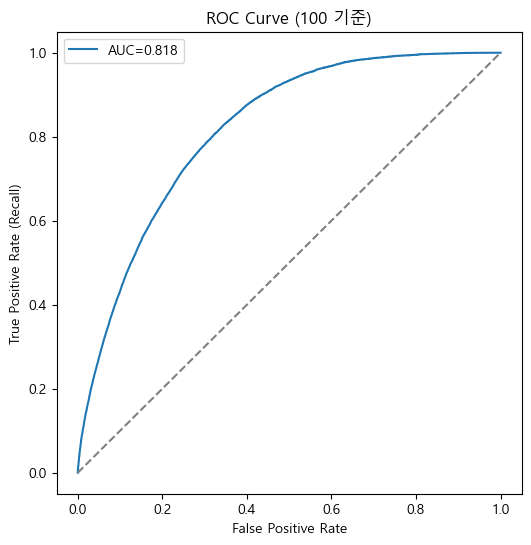

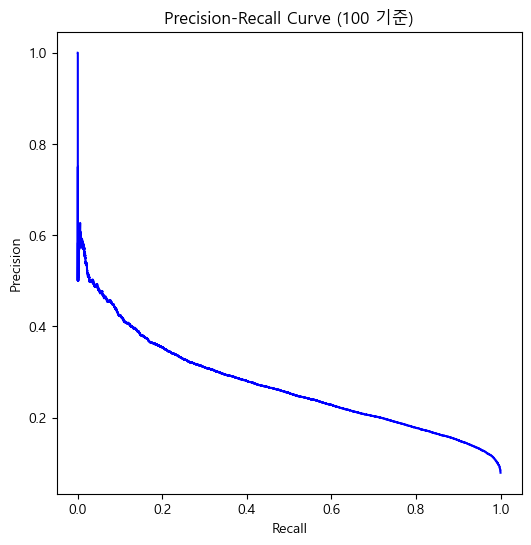

In [27]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -----------------------------
# 1. 데이터 준비 (100 기준)
# -----------------------------
target = "고혈당_분석용"   # 100 기준
y = df[target].astype("int")

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]
X = df.drop(columns=exclude_cols, errors="ignore")

cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X = X.astype("float32")

# -----------------------------
# 2. train-test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 클래스 불균형 비율
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos if pos > 0 else 1
print(f"scale_pos_weight ≈ {scale:.2f}")

# -----------------------------
# 3. LightGBM 모델 (최적화)
# -----------------------------
lgb_model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight={0:1, 1:scale},
    n_jobs=-1
)

# ✅ callbacks로 early stopping 적용
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[early_stopping(100), log_evaluation(100)]
)

# -----------------------------
# 4. 성능 평가
# -----------------------------
y_pred_proba = lgb_model.predict_proba(X_test)[:,1]

# ROC-AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC = {auc:.3f}")

# 최적 threshold (F1 기준)
prec, rec, thresh = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = np.argmax(f1_scores)
best_thresh = thresh[best_idx]

print(f"✅ 최적 Threshold = {best_thresh:.2f}")
print(f"Precision = {prec[best_idx]:.2f}, Recall = {rec[best_idx]:.2f}, F1 = {f1_scores[best_idx]:.2f}")

# -----------------------------
# 5. 세분류 기준 함수
# -----------------------------
def map_risk(prob):
    # 구간은 필요에 맞게 조정 가능
    if prob >= best_thresh:        # 최적 threshold 이상
        return "🚨 위험"
    elif prob >= 0.4:              # 중간 구간
        return "⚠️ 경고"
    else:
        return "✅ 주의"

# -----------------------------
# 6. 결과 적용
# -----------------------------
risk_labels = [map_risk(p) for p in y_pred_proba]

df_result = pd.DataFrame({
    "예측확률": y_pred_proba,
    "예측등급": risk_labels,
    "실제값": y_test.values
})

print(df_result.head(20))

# -----------------------------
# 7. 분포 확인
# -----------------------------
print("\n📊 위험도 분포")
print(df_result["예측등급"].value_counts())

# -----------------------------
# 8. ROC Curve & PR Curve 시각화
# -----------------------------
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (100 기준)")
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
plt.plot(rec, prec, color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (100 기준)")
plt.show()


In [28]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -----------------------------
# 1. 데이터 준비 (100 기준)
# -----------------------------
target = "고혈당_분석용"   # 100 기준
y = df[target].astype("int")

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]
X = df.drop(columns=exclude_cols, errors="ignore")

cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X = X.astype("float32")

# -----------------------------
# 2. train-test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 클래스 불균형 비율
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos if pos > 0 else 1
print(f"scale_pos_weight ≈ {scale:.2f}")

# -----------------------------
# 3. LightGBM 모델 (최적화)
# -----------------------------
lgb_model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight={0:1, 1:scale},
    n_jobs=-1
)

# ✅ callbacks로 early stopping 적용
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[early_stopping(100), log_evaluation(100)]
)

# -----------------------------
# 4. 성능 평가
# -----------------------------
y_pred_proba = lgb_model.predict_proba(X_test)[:,1]

# ROC-AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC = {auc:.3f}")

# 최적 threshold (F1 기준)
prec, rec, thresh = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = np.argmax(f1_scores)
best_thresh = thresh[best_idx]

print(f"✅ 최적 Threshold = {best_thresh:.2f}")
print(f"Precision = {prec[best_idx]:.2f}, Recall = {rec[best_idx]:.2f}, F1 = {f1_scores[best_idx]:.2f}")

# -----------------------------
# 5. 최적 threshold 적용 결과
# -----------------------------
y_pred_best = (y_pred_proba >= best_thresh).astype(int)
print("\n📊 LightGBM (100 기준, 최적 Threshold 적용)")
print(classification_report(y_test, y_pred_best))

# -----------------------------
# 6. 다양한 Threshold 비교 (0.3 ~ 0.9, step=0.05)
# -----------------------------
thresholds = np.arange(0.3, 0.91, 0.05)
results = []

for thr in thresholds:
    y_pred_thr = (y_pred_proba >= thr).astype(int)
    
    # Precision, Recall, F1 계산
    prec_thr = np.sum((y_test==1) & (y_pred_thr==1)) / max(np.sum(y_pred_thr==1), 1)
    rec_thr = np.sum((y_test==1) & (y_pred_thr==1)) / max(np.sum(y_test==1), 1)
    f1_thr = 2 * prec_thr * rec_thr / (prec_thr + rec_thr + 1e-6)
    
    results.append([thr, prec_thr, rec_thr, f1_thr])

# 결과를 DataFrame으로 정리
thr_df = pd.DataFrame(results, columns=["Threshold","Precision","Recall","F1"])
print("\n📊 Threshold별 성능 비교")
print(thr_df)

# 가장 F1이 높은 threshold 선택
best_row = thr_df.iloc[thr_df["F1"].idxmax()]
print(f"\n✅ 가장 좋은 Threshold = {best_row['Threshold']:.2f}")
print(f"Precision = {best_row['Precision']:.2f}, Recall = {best_row['Recall']:.2f}, F1 = {best_row['F1']:.2f}")

# -----------------------------
# 7. 최적 threshold 적용 결과 리포트
# -----------------------------
y_pred_best = (y_pred_proba >= best_row["Threshold"]).astype(int)
print("\n📊 LightGBM (100 기준, 최적 Threshold 적용)")
print(classification_report(y_test, y_pred_best))


scale_pos_weight ≈ 11.76
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.794961	valid_0's binary_logloss: 0.588006
[200]	valid_0's auc: 0.802347	valid_0's binary_logloss: 0.558423
[300]	valid_0's auc: 0.807668	valid_0's binary_logloss: 0.545547
[400]	valid_0's auc: 0.810982	valid_0's binary_logloss: 0.538779
[500]	valid_0's auc: 0.813196	valid_0's binary_logloss: 0.534624
[600]	valid_0's auc: 0.814788	valid_0's binary_logloss: 0.531783
[700]	valid_0's auc: 0.815831	valid_0's binary_logloss: 0.529843
[800]	valid_0's auc: 0.81655	valid_0's binary_logloss: 0.528411
[900]	valid_0's auc: 0.817006	valid_0's binary_logloss: 0.527326
[1000]	valid_0's auc: 0.817396	valid_0's binary_logloss: 0.526352
[1100]	valid_0's auc: 0.817634	valid_0's binary_logloss: 0.525577
[1200]	valid_0's auc: 0.817827	valid_0's binary_logloss: 0.524877
[1300]	valid_0's auc: 0.817967	valid_0's binary_logloss: 0.524231
[1400]	valid_0's auc: 0.818093	valid_0's binary_logloss: 0.523585

In [29]:

target = "고혈당_분석용"  
y = df[target]


exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]
X = df.drop(columns=exclude_cols, errors="ignore")


cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")



from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale
)

xgb_model.fit(X_train, y_train)


print("📊 XGBoost (class weight 적용)")
print(classification_report(y_test, xgb_model.predict(X_test)))

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 예측 확률
y_pred_proba = xgb_model.predict_proba(X_test)[:,1]

thresholds = np.arange(0.3, 0.71, 0.05)
results = []

for thr in thresholds:
    y_pred_thr = (y_pred_proba >= thr).astype(int)
    
    acc = accuracy_score(y_test, y_pred_thr)
    prec = precision_score(y_test, y_pred_thr, zero_division=0)
    rec = recall_score(y_test, y_pred_thr, zero_division=0)
    f1 = f1_score(y_test, y_pred_thr, zero_division=0)
    
    results.append([thr, acc, prec, rec, f1])

thr_df = pd.DataFrame(results, columns=["Threshold","Accuracy","Precision","Recall","F1"])

print("\n📊 Threshold별 성능 비교 (XGBoost)")
print(thr_df)

# 가장 F1이 높은 threshold
best_row = thr_df.iloc[thr_df["F1"].idxmax()]
print(f"\n✅ 가장 좋은 Threshold = {best_row['Threshold']:.2f}")
print(f"Accuracy = {best_row['Accuracy']:.3f}, Precision = {best_row['Precision']:.3f}, Recall = {best_row['Recall']:.3f}, F1 = {best_row['F1']:.3f}")


scale_pos_weight = 11.76
📊 XGBoost (class weight 적용)
              precision    recall  f1-score   support

           0       0.97      0.69      0.81    184213
           1       0.18      0.79      0.29     15787

    accuracy                           0.70    200000
   macro avg       0.58      0.74      0.55    200000
weighted avg       0.91      0.70      0.77    200000


📊 Threshold별 성능 비교 (XGBoost)
   Threshold  Accuracy  Precision    Recall        F1
0       0.30  0.538900   0.138768  0.929942  0.241500
1       0.35  0.578660   0.147183  0.904795  0.253182
2       0.40  0.618200   0.156565  0.874580  0.265586
3       0.45  0.659355   0.167594  0.835814  0.279203
4       0.50  0.700215   0.180141  0.787863  0.293235
5       0.55  0.740555   0.194475  0.727814  0.306936
6       0.60  0.781210   0.211942  0.651802  0.319873
7       0.65  0.819810   0.234204  0.565149  0.331168
8       0.70  0.855490   0.262865  0.460442  0.334669

✅ 가장 좋은 Threshold = 0.70
Accuracy = 0.855, Precis

In [31]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# risk_score 기반 예측: threshold = 4 이상이면 고혈당으로 분류
y_pred_rule = (df['risk_score'] >= 4).astype(int)

print("📊 Risk Score 단독 성능")
print(classification_report(y, y_pred_rule))
print("ROC-AUC:", roc_auc_score(y, df['risk_score']))


📊 Risk Score 단독 성능
              precision    recall  f1-score   support

           0       0.96      0.51      0.67    921528
           1       0.12      0.76      0.20     78472

    accuracy                           0.53   1000000
   macro avg       0.54      0.64      0.44   1000000
weighted avg       0.90      0.53      0.63   1000000

ROC-AUC: 0.6898439308242351


In [32]:
# 머신러닝 확률 예측 (예: LightGBM)
y_pred_ml_proba = lgb_model.predict_proba(X_test)[:,1]

# risk_score를 [0~1] 범위로 정규화
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
risk_norm = scaler.fit_transform(df[['risk_score']])

# 앙상블: 머신러닝 확률과 risk_score 비율 조합
alpha = 0.7  # 머신러닝 비중
ensemble_score = alpha*y_pred_ml_proba + (1-alpha)*risk_norm[X_test.index].flatten()

# 최종 분류
y_pred_ensemble = (ensemble_score >= 0.5).astype(int)

print("📊 앙상블 성능")
print(classification_report(y_test, y_pred_ensemble))
print("ROC-AUC:", roc_auc_score(y_test, ensemble_score))


📊 앙상블 성능
              precision    recall  f1-score   support

           0       0.97      0.76      0.85    184213
           1       0.20      0.70      0.31     15787

    accuracy                           0.75    200000
   macro avg       0.58      0.73      0.58    200000
weighted avg       0.91      0.75      0.81    200000

ROC-AUC: 0.8117419025678896


In [33]:
# -----------------------------
# 1. 새로운 파생변수 생성
# -----------------------------
df["BMI"] = df["체중(5kg단위)"] * 5 / ((df["신장(5cm단위)"]*5 / 100) ** 2)   # 단위 보정
df["혈압차"] = df["수축기혈압"] - df["이완기혈압"]
df["콜레스테롤비율"] = df["총콜레스테롤"] / (df["HDL콜레스테롤"] + 1e-6)
df["AST_ALT비율"] = df["혈청지오티(AST)"] / (df["혈청지피티(ALT)"] + 1e-6)
# 입력가능한 피쳐만 추가해서  성능 향상으로 

# -----------------------------
# 2. 피처/타깃 분리
# -----------------------------
target = "고혈당_분석용"
y = df[target].astype(int)

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]
X = df.drop(columns=exclude_cols, errors="ignore")

cat_cols = ["성별코드","흡연상태","음주여부"]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X = X.astype("float32").fillna(0)

# -----------------------------
# 3. 모델 학습 & Threshold 실험
# -----------------------------
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

neg, pos = (y_train==0).sum(), (y_train==1).sum()
scale = neg / pos if pos > 0 else 1

model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight={0:1, 1:scale},
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# 예측 확률
y_pred_proba = model.predict_proba(X_test)[:,1]

# 여러 Threshold에서 성능 확인
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Threshold={t:.2f} → Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}, AUC={auc:.3f}")


Threshold=0.30 → Precision=0.140, Recall=0.929, F1=0.243, AUC=0.817
Threshold=0.40 → Precision=0.157, Recall=0.871, F1=0.266, AUC=0.817
Threshold=0.50 → Precision=0.180, Recall=0.787, F1=0.293, AUC=0.817
Threshold=0.60 → Precision=0.213, Recall=0.661, F1=0.322, AUC=0.817
Threshold=0.70 → Precision=0.262, Recall=0.461, F1=0.334, AUC=0.817


In [36]:
# -----------------------------
# 1. 새로운 파생변수 생성
# -----------------------------
df["BMI"] = df["체중(5kg단위)"] * 5 / ((df["신장(5cm단위)"]*5 / 100) ** 2)   # 단위 보정
df["혈압차"] = df["수축기혈압"] - df["이완기혈압"]
df["콜레스테롤비율"] = df["총콜레스테롤"] / (df["HDL콜레스테롤"] + 1e-6)
df["AST_ALT비율"] = df["혈청지오티(AST)"] / (df["혈청지피티(ALT)"] + 1e-6)

# -----------------------------
# 2. 피처/타깃 분리
# -----------------------------
target = "고혈당_분석용"
y = df[target].astype(int)

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]

# 치아 관련 변수 강제 포함
dental_cols = [c for c in ["치아우식증유무",] if c in df.columns]

X = df.drop(columns=exclude_cols, errors="ignore")

# 카테고리형 변수 인코딩
cat_cols = ["성별코드","흡연상태","음주여부"] + dental_cols
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# float32로 변환 + 결측값 처리
X = X.astype("float32").fillna(0)

# -----------------------------
# 3. 모델 학습 & Threshold 실험
# -----------------------------
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

neg, pos = (y_train==0).sum(), (y_train==1).sum()
scale = neg / pos if pos > 0 else 1

model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight={0:1, 1:scale},
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# 예측 확률
y_pred_proba = model.predict_proba(X_test)[:,1]

# 여러 Threshold에서 성능 확인
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Threshold={t:.2f} → Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}, AUC={auc:.3f}")


Threshold=0.30 → Precision=0.140, Recall=0.929, F1=0.243, AUC=0.818
Threshold=0.40 → Precision=0.157, Recall=0.874, F1=0.267, AUC=0.818
Threshold=0.50 → Precision=0.180, Recall=0.787, F1=0.292, AUC=0.818
Threshold=0.60 → Precision=0.213, Recall=0.661, F1=0.322, AUC=0.818
Threshold=0.70 → Precision=0.262, Recall=0.461, F1=0.334, AUC=0.818


In [ ]:
# -----------------------------
# 1. 새로운 파생변수 생성
# -----------------------------
df["BMI"] = df["체중(5kg단위)"] * 5 / ((df["신장(5cm단위)"]*5 / 100) ** 2)   # 단위 보정
df["혈압차"] = df["수축기혈압"] - df["이완기혈압"]
df["콜레스테롤비율"] = df["총콜레스테롤"] / (df["HDL콜레스테롤"] + 1e-6)
df["AST_ALT비율"] = df["혈청지오티(AST)"] / (df["혈청지피티(ALT)"] + 1e-6)

# -----------------------------
# 2. 피처/타깃 분리
# -----------------------------
target = "고혈당_3class"
y = df[target].astype(int)

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level"]

# 치아 관련 변수 강제 포함
dental_cols = [c for c in ["치아우식증유무"] if c in df.columns]

X = df.drop(columns=exclude_cols, errors="ignore")

# 카테고리형 변수 인코딩
cat_cols = ["성별코드","흡연상태","음주여부"] + dental_cols
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# float32로 변환 + 결측값 처리
X = X.astype("float32").fillna(0)

# -----------------------------
# 3. 모델 학습 & Threshold 실험
# -----------------------------
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

neg, pos = (y_train==0).sum(), (y_train==1).sum()
scale = neg / pos if pos > 0 else 1

model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight={0:1, 1:scale},
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# 예측 확률
y_pred_proba = model.predict_proba(X_test)[:,1]

# 여러 Threshold에서 성능 확인
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Threshold={t:.2f} → Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}, AUC={auc:.3f}")

# -----------------------------
# 1. 새로운 타깃 생성 (3-class)
# -----------------------------
def new_target(glucose):
    if glucose >= 126:
        return 2   # 고위험군
    elif glucose >= 100:
        return 1   # 경계군
    else:
        return 0   # 정상

df["고혈당_3class"] = df["식전혈당(공복혈당)"].apply(new_target)

# -----------------------------
# 2. 피처/타깃 분리
# -----------------------------
target = "고혈당_3class"
y = df[target].astype(int)

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level","고혈당_3class"]

dental_cols = [c for c in ["치아우식증유무"] if c in df.columns]
X = df.drop(columns=exclude_cols, errors="ignore")

cat_cols = ["성별코드","흡연상태","음주여부"] + dental_cols
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X = X.astype("float32").fillna(0)

# -----------------------------
# 3. 모델 학습 (multiclass)
# -----------------------------
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multiclass",   # ✅ 멀티클래스
    num_class=3,              # ✅ 클래스 개수 지정
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# -----------------------------
# 4. 성능 평가
# -----------------------------
y_pred = model.predict(X_test)
print("\n📊 LightGBM (3-class)")
print(classification_report(y_test, y_pred))


In [37]:
# -----------------------------
# 1. 타깃 (3-class) 생성
# -----------------------------
def new_target(glucose):
    if glucose >= 126:
        return 2   # 고위험군
    elif glucose >= 100:
        return 1   # 경계군
    else:
        return 0   # 정상

df["고혈당_3class"] = df["식전혈당(공복혈당)"].apply(new_target)

# -----------------------------
# 2. 피처/타깃 분리
# -----------------------------
target = "고혈당_3class"
y = df[target].astype(int)

exclude_cols = ["고혈당_분석용","고혈당_서비스용","식전혈당(공복혈당)","risk_level","고혈당_3class"]
dental_cols = [c for c in ["치아우식증유무"] if c in df.columns]

X = df.drop(columns=exclude_cols, errors="ignore")

cat_cols = ["성별코드","흡연상태","음주여부"] + dental_cols
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X = X.astype("float32").fillna(0)

# -----------------------------
# 3. Train-Test Split
# -----------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# -----------------------------
# 4. LightGBM 학습 (클래스 가중치 조정)
# -----------------------------
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 클래스 불균형 보정 (정상:1, 경계:3, 고위험:6)
weights = {0:1, 1:3, 2:6}

model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multiclass",
    num_class=3,
    class_weight=weights,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# -----------------------------
# 5. 확률 예측 + Threshold 튜닝
# -----------------------------
y_proba = model.predict_proba(X_test)

# 기본은 argmax
y_pred = y_proba.argmax(axis=1)

# 커스텀 Threshold 적용
# 예) 고위험군 확률 >= 0.25면 무조건 "2"
y_pred_custom = []
for p in y_proba:
    if p[2] >= 0.25:
        y_pred_custom.append(2)
    elif p[1] >= 0.4:  # 경계군 확률 0.4 이상이면 "1"
        y_pred_custom.append(1)
    else:
        y_pred_custom.append(0)
y_pred_custom = np.array(y_pred_custom)

# -----------------------------
# 6. Risk Score 앙상블
# -----------------------------
def apply_risk_score(row, pred, risk_threshold=7):
    if row["risk_score"] >= risk_threshold:
        return 2   # 고위험군으로 강제 조정
    return pred

y_pred_final = [
    apply_risk_score(df.iloc[idx], pred) 
    for idx, pred in zip(y_test.index, y_pred_custom)
]

# -----------------------------
# 7. 성능 평가 
# -----------------------------
print("\n📊 LightGBM + Class Weights + Threshold + Risk Score 앙상블")
print(classification_report(y_test, y_pred_final))
print("\n혼동행렬:")
print(confusion_matrix(y_test, y_pred_final))



📊 LightGBM + Class Weights + Threshold + Risk Score 앙상블
              precision    recall  f1-score   support

           0       0.87      0.33      0.48    120516
           1       0.33      0.43      0.38     63790
           2       0.17      0.78      0.28     15694

    accuracy                           0.40    200000
   macro avg       0.46      0.51      0.38    200000
weighted avg       0.65      0.40      0.43    200000


혼동행렬:
[[39747 52734 28035]
 [ 5514 27735 30541]
 [  238  3255 12201]]
